In [9]:
import cv2
import numpy as np
import math
from matplotlib import pyplot as plt

In [2]:
def partial_shadow(sun_radius):
    arr = np.linspace(0, 2, sun_radius * 2 + 1)
    arr = np.delete(arr + (arr[1] - arr[0]) / 2, -1)
    shadow_arr = (np.arccos(1 - arr) - (1 - arr) * np.sqrt(2 * arr - arr ** 2)) / np.pi

    return shadow_arr

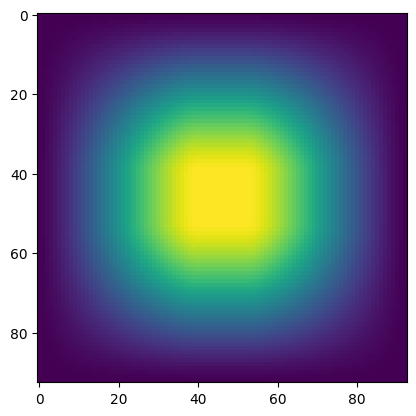

In [8]:
# partial shadow distance is 2r of the sun

def solar_cell_mask(cell_size, distance, pix_deg, sun_radius):
    cell_x = cell_size[0]
    cell_y = cell_size[1]

    projection_x = 2 * math.degrees(math.atan(cell_x / distance / 2)) * pix_deg
    projection_y = 2 * math.degrees(math.atan(cell_y / distance / 2)) * pix_deg

    size_x = int(projection_x + 2 * sun_radius)
    size_y = int(projection_y + 2 * sun_radius)

    mask = np.ones((size_x, size_y))

    shadow_arr = partial_shadow(sun_radius)

    mask[0:sun_radius * 2, :] *= shadow_arr[:, None] # top
    mask[-sun_radius * 2:,:] *= np.flip(shadow_arr)[:, None] # bottom
    mask[:, 0:sun_radius * 2] *= shadow_arr[None, :] # left
    mask[:,-sun_radius * 2:] *= np.flip(shadow_arr)[None, :] # right

    return (projection_x, projection_y), mask

plt.imshow(solar_cell_mask((0.21,0.21), 14, 4048/65, 20)[2])

In [ ]:
def solar_module_mask(cell_size, shape, spacing, pos, distance, pix_deg, sun_radius):

    cell_projection, cell_mask = solar_cell_mask(cell_size, distance, pix_deg, sun_radius)

    size = shape * (cell_projection + spacing * cell_projection / cell_size)
    start_pos = pos - size / 2


    cell_row = []

In [ ]:
filename = input("Filename: ")
tree_img = cv2.imread('measuredTrees/' + filename)
plt.imshow(tree_img)

In [ ]:
distance = 5
pos_az = 10

variation = 200

sun_radius_deg = 0.533

res_x = tree_img.shape[1]
res_y = tree_img.shape[0]
pix_deg = res_x / 65

In [ ]:
lower_bound = np.array([205, 0, 0])
upper_bound = np.array([360, 255, 255])

mask = cv2.inRange(tree_img, lower_bound, upper_bound)

#cv2.imshow('treemask', imagemask)
plt.imshow(mask, cmap='gray')

In [ ]:
sun_x = int(input("Sun position X: "))#1517
sun_y = int(input("Sun position Y: "))#1467

sun_radius = int(sun_radius_deg * pix_deg) // 2

pos_x = np.arange(sun_x-sun_radius*4, sun_x+sun_radius*4, int(sun_radius/8))
pos_y = np.arange(sun_y-sun_radius*4, sun_y+sun_radius*4, int(sun_radius/8))

coords = np.array(np.meshgrid(pos_x, pos_y, )).T.reshape(-1, 2)